### 特征工程 feature engineering
- feature extraction: 从文字、图像、声音等非结构化数据中提取新信息作为特征。如从淘宝商品的名称中提取产品类型等
- feature creation： 把现有特征组合或相互计算，得到新的特征。
- feature selection： 选择有意义的特征，选出对模型有帮助的特征，避免将所有特征都导入



## 特征选择
选择有意义的特征，选出对模型有帮助的特征，避免将所有特征都导入

无法依赖对业务的理解来选择特征：过滤法、嵌入法、包装法and降维算法

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# from sklearn.feature_selection import 

In [5]:
data = pd.read_csv(r'./digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X.shape

(42000, 784)

### Filter过滤法
通常用作预处理步骤，独立于任何机器学习算法，主要根据各种统计检验的指标来选择特征

- 方差过滤：，可以删除。
特征和标签之间的关联性
- 卡方过滤：
- F检验和互信息法：

#### 方差过滤
特征方差较小，表明样本在这个特征上差别不大，甚至相同，这样的特征无意义

In [7]:
from sklearn.feature_selection import VarianceThreshold
# 该类的参数为threshold
selector = VarianceThreshold() # 实例化，默认参数为0
x_var0 = selector.fit_transform(X)  # 获取删除不合格特征之后的新特征矩阵，narray
x_var0.shape

(42000, 708)

In [11]:
# 进一步减少特征， 如减少到一半， 采取中位数
# - 如何取到中位数
X.var() # Series对象
np.median(X.var().values)
# 考虑前50或前100个特征
# -将X.var()排序后取出相应值然后放入threshold

1352.286703180131

In [9]:
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

In [10]:
X_fsvar.shape

(42000, 392)

二分类的特征，其取值为伯努利随机变量，方差为：
$$Var[X]=p(1-p)$$
其中X为特征矩阵，p是二分类特征中的一类在这个特征中的概率。

某种分类占到80%以上删除特征。

In [12]:
x_bvar = VarianceThreshold(0.8*(1-0.8)).fit_transform(X)
x_bvar.shape

(42000, 685)

In [17]:
# 实例：方差过滤对模型的影响
# Time Warning： 4h
# kNN vs RFC在不同方差过滤效果下的对比
# kNN必须遍历每个特征和每个样本：故其不适用于大量样本的数据
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score

x = data.iloc[:,1:] # 过滤前的特征矩阵
y = data.iloc[:,0]

x_fsvar = VarianceThreshold(np.median(x.var().values)).fit_transform(x)  # 方差过滤后1

In [ ]:
x_fsvar.shape

In [ ]:
%% timeit #每个cell运行的时间
cross_val_score(KNN(),x,y,cv=5).mean()
# 0.9656 30min

In [ ]:
%% timeit 
cross_val_score(KNN(),x_fsvar,y,cv=5).mean()
# 0.9689 20min

In [25]:
cross_val_score(RFC(n_estimators=10, random_state=0),x,y,cv=5).mean()


0.9380003861799541

In [23]:
%%timeit
cross_val_score(RFC(n_estimators=10, random_state=0),x,y,cv=5).mean()
# 0.9388 11.1s

9.27 s ± 96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
cross_val_score(RFC(n_estimators=10, random_state=0),x_fsvar,y,cv=5).mean()


0.9388098166696807

In [37]:
cross_val_score(RFC(n_estimators=10, random_state=0), x_var0,y,cv=5).mean()

0.9385004515100317

In [22]:
%%timeit
cross_val_score(RFC(n_estimators=10, random_state=0),x_fsvar,y,cv=5).mean()


9.29 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- 为什么RF>>KNN?且方差过滤对随机森林没有很大影响？

这是因为原理不同。KNN，单棵决策树、SVM、神经网络，回归算法，都需要遍历特征或升维来进行运算，本身运算量大，所以方差对他们来说很重要。但对于不需要遍历特征的算法，如随机森林随机选择特征进行分枝，本身运算速度快。且无论过滤法如何减少特征，随机森林都只会选取固定的数量的特征来建模，故方差过滤对其影响不大。
> 过滤法的主要对象：需要遍历特征或升维的算法。
> 过滤法的主要目的：在保证算法的表现下，减少特征数量来减少计算成本。

- 为什么说方差过滤常常用作数据预处理？
方差过滤：不一定保证模型表现会变好。当threshold较大时，可能会滤除有效特征。

怎么选择方差阈值：阈值为0或者较小，来消除一些明显用不到的特征。然后采取其他的特征选择方法来进一步进行特征工程。

#### 卡方过滤
针对离散型标签（即分类问题的相关性过滤），非负特征和标签之间的卡方统计量，并按照卡方统计量由高到低为特征排名。再用SelectKBest来选取前K个特征。

In [18]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

X_fschi = SelectKBest(chi2, k=300).fit_transform(x_fsvar,y)
X_fschi.shape


(42000, 300)

In [20]:
# 随机森林分类
cross_val_score(RFC(n_estimators=10, random_state=0), X_fschi,y,cv=5).mean()

0.9333098667649198

与x_fsvar相比较而言0.9388，效果降低，说明过滤了有效特征
- 怎样选取K：学习曲线（时间长）-> P值选择k
显著性水平p<0.05/0.01->数据相关，从chi2实例化的模型中的

In [38]:
chivalue, pvalues_chi = chi2(x_fsvar,y)

In [39]:
chivalue.shape

(392,)

In [33]:
pvalues_chi

array([3.37556612e-202, 0.00000000e+000, 0.00000000e+000, 8.14984992e-014,
       4.82170664e-027, 1.08842996e-102, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       2.39754926e-120, 4.63737072e-052, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.91066191e-304,
       3.65562117e-249, 1.41443562e-112, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [40]:
# k值怎么取，消除p值大于显著性水平的特征
k = chivalue.shape[0] - (pvalues_chi>0.05).sum()
k

392

经过方差过滤后的特征经卡方检验均为有效特征，不需要过滤

#### F检验
ANOVA，既可以回归也可分类，用来捕捉每个特征于标签之间的线性关系的过滤方法。
数据服从正太分布效果时效果稳定，预处理.
- SelectKBest
- 原假设：数据不存在显著的线性关系。<0.05，相关

In [41]:
from sklearn.feature_selection import f_classif

F, pvaluse_f = f_classif(x_fsvar,y)

In [43]:
F.shape

(392,)

In [48]:
# 不线性相关的特征个数
(pvaluse_f>0.01).sum()

0

经过方差过滤后的特征经F检验均为线性有关，不需要过滤

#### 互信息法
既可以回归也可分类，用来捕捉每个特征于标签之间的**任意关系**（包括西南行和非线性）的过滤方法。比F检验更加强大
- 不返回p值或F值类似的统计量，返回每个特征与目标之间的互信息量的估计，返回[0,1]（[独立,完全相关]）

In [49]:
from sklearn.feature_selection import mutual_info_classif as MIC

result = MIC(x_fsvar, y)

In [51]:
(result>0).sum()

392

In [52]:
x_fsmic = SelectKBest(MIC,k=300).fit_transform(x,y)

In [54]:
x_fsmic.shape

(42000, 300)

In [55]:
cross_val_score(RFC(n_estimators=10, random_state=0),x_fsmic,y,cv=10).mean()

0.9398328527673006

### 包裹式
包裹式特征选择直接把最终要使用的学习器性能作为特征子集的评价标准。para:estimator:带coef_,feature_importances_属性或者l1/l2惩罚项**实例化之后才能运行**
threshold: 特征重要性阈值

In [56]:
from sklearn.feature_selection import SelectFromModel

RFC_ = RFC(n_estimators=10,random_state=0)
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y)


In [58]:
# 0.005是比较高的阈值，按重要性分每个特征1/782约为0.001
# 此处筛出了较多特征
X_embedded.shape

(42000, 47)

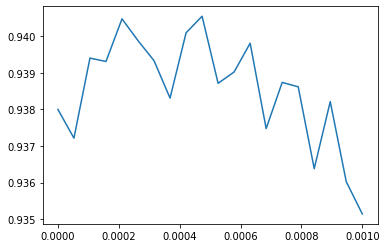

In [62]:
# 怎么选取threshold
# 学习曲线， 只有学习曲线？
RFC_.fit(x,y).feature_importances_
threshold = np.linspace(0,(RFC_.fit(x,y).feature_importances_).max(),20)# 必须传入实例化的评估器
threshold = np.linspace(0,0.001,20) # 进一步细化
score = []

for th in threshold:
    RFEX_embedded = SelectFromModel(RFC_, th).fit_transform(X,y)
    s = cross_val_score(RFC_, X_embedded,y,cv=5).mean()
    score.append(s)
    
plt.plot(threshold, score)
plt.show()

In [63]:
X_embedded = SelectFromModel(RFC_, 0.001).fit_transform(X,y)


In [64]:
X_embedded.shape

(42000, 279)

In [65]:
cross_val_score(RFC_, X_embedded,y,cv=5).mean()

0.9351434640469405

### 嵌入法
较小的特征数量，有效的组合，高效。

嵌入式特征选择将特征选择过程与学习器训练过程融为一体，两者在同一优化过程中完成,黑河中的算法不是目标算法（RF）,而是数据挖掘算法，每一次递归的使用修剪后的特征，而不是所有特征。

class sklearn.feature_selection.RFE(estimator,n_feature_to_select=None,step=1)

n_feature_to_select: 要选择特征的个数

step:每次递归删除的特征
- RFE类的两个重要属性：.support_:返回所有特征最后是否被选中的特征矩阵
                    
                    .ranking返回特征的按数次迭代中综合重要性的排名，在前面越重要
- RFEcv，增加参数cv

In [78]:
from sklearn.feature_selection import RFE

RFC_ = RFC(n_estimators=100,random_state=0)

In [67]:
selector = RFE(RFC_,n_features_to_select=340, step=50).fit(X,y)

In [71]:
selector.support_.sum()

340

In [75]:
selector.ranking_.shape

(784,)

In [76]:
X_wrapper = selector.transform(X)

In [79]:
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()

0.9637148832441458

### conclusion

当**数据量很大**的时候，优先使用方差过滤和互信息法调整，再加上其他特征选择方法。使用**逻辑回归**时，优先使用Embedded。使用**SVM**，优先采用包装法。迷茫时，从过滤法开始，具体数据具体分析。

特征选择只是特征工程中的第一步，特征创造或者特征提取来寻找高级特征。